*Let's load all Billboard Hot 100 Charts from our chart data into one dataframe.*

In [36]:

import pandas as pd
import os

years = ["2023", "2024", "2025"]

total_hot_100 = pd.DataFrame()

for year in years:

    file_count = 0
    
    for file in os.listdir(f"chart_data/hot-100/{year}"):

        total_hot_100 = pd.concat([total_hot_100, pd.read_csv(f"chart_data/hot-100/{year}/{file}")])
        file_count += 1
        
    print(f"Added {file_count} files to hot_100 from {year}")

Added 52 files to hot_100 from 2023
Added 52 files to hot_100 from 2024
Added 34 files to hot_100 from 2025


*.listdir() doesn't inherently keep sorting, so let's do this now.*

In [37]:
total_hot_100 = total_hot_100.sort_values("chart_week", ascending=True).reset_index(drop=True)
total_hot_100[total_hot_100["wks_on_chart"] == 1]["title"].unique()

array(['Gato de Noche', 'Bebe Dame', 'Que Vuelvas', ...,
       'Let That Sink In', 'Hell At Night', 'Just Say Dat'],
      shape=(1618,), dtype=object)

*Ok, I want to visualize the distribution of the wks_on_chart field, so I need to remove duplicate song rows and leave only the row with greatest count*

In [33]:
weeks_on_chart_df = total_hot_100
weeks_on_chart_df.sort_values(by="wks_on_chart", ascending=False)
weeks_on_chart_df = weeks_on_chart_df.groupby("title")["wks_on_chart"].max().reset_index()
mask = weeks_on_chart_df["title"].str.contains("(There's No Place Like)", case=False, regex=True)
df_remixes = weeks_on_chart_df[mask]
df_remixes["title"].iloc[1]

/var/folders/cm/mn8_9bt54zzgsk6vsch81r8w0000gn/T/ipykernel_49931/944033321.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = weeks_on_chart_df["title"].str.contains("(There's No Place Like)", case=False, regex=True)


"(There's No Place Like) Home For The Holidays (1959)"

In [13]:
import numpy as np

print(f"Max weeks on chart: {np.max(total_hot_100['wks_on_chart'])}")
print(f"Mean weeks on chart: {np.ceil(np.mean(weeks_on_chart_df['wks_on_chart']))}")
print(f"Median weeks on chart: {round(np.median(total_hot_100['wks_on_chart']), 1)}")
print(f"Standard deviation of weeks on chart: {round(np.std(total_hot_100['wks_on_chart']), 1)}")

# Let's do a quick check for the most popular song
longest = total_hot_100.sort_values("wks_on_chart", ascending=True).head(40)
longest

Max weeks on chart: 104
Mean weeks on chart: 9.0
Median weeks on chart: 9.0
Standard deviation of weeks on chart: 13.3


,chart_week,current_week,title,performer,last_week,peak_pos,wks_on_chart
5181,2022-12-24,54,Open Arms,SZA Featuring Travis Scott,-,54,1
16303,2025-02-15,45,Wake Me Up,The Weeknd & Justice,-,45,1
3770,2022-09-17,100,Sin Fin,Romeo Santos & Justin Timberlake,-,100,1
9197,2023-09-30,33,Greedy,Tate McRae,-,33,1
16293,2025-02-08,1,4X4,Travis Scott,-,1,1
1818,2022-05-07,15,Thousand Miles,The Kid LAROI,-,15,1
3768,2022-09-17,98,Static,Steve Lacy,-,98,1
10679,2024-01-13,71,23,Chayce Beckham,-,71,1
16288,2025-02-08,17,Fat Juicy & Wet,Sexyy Red & Bruno Mars,-,17,1
3765,2022-09-17,91,Calm Down,Rema & Selena Gomez,-,91,1


In [174]:
two_random = weeks_on_chart_df[weeks_on_chart_df["wks_on_chart"] == np.ceil(weeks_on_chart_df["wks_on_chart"].mean())].sample(2, random_state=340940)
two_random

,title,wks_on_chart
1133,Lagunas,9
708,Folded,9


In [177]:
total_hot_100[total_hot_100["title"] == "Disease"].sort_values(by="wks_on_chart", ascending=True)

,chart_week,current_week,title,performer,last_week,peak_pos,wks_on_chart
14996,2024-11-09,27,Disease,Lady Gaga,-,27,1
15079,2024-11-16,58,Disease,Lady Gaga,27,27,2
15107,2024-11-23,56,Disease,Lady Gaga,58,27,3
15216,2024-11-30,59,Disease,Lady Gaga,56,27,4
15340,2024-12-07,76,Disease,Lady Gaga,59,27,5
15483,2024-12-14,89,Disease,Lady Gaga,76,27,6
15628,2024-12-28,98,Disease,Lady Gaga,-,27,7
15844,2025-01-11,80,Disease,Lady Gaga,-,27,8
16809,2025-03-22,71,Disease,Lady Gaga,-,27,9


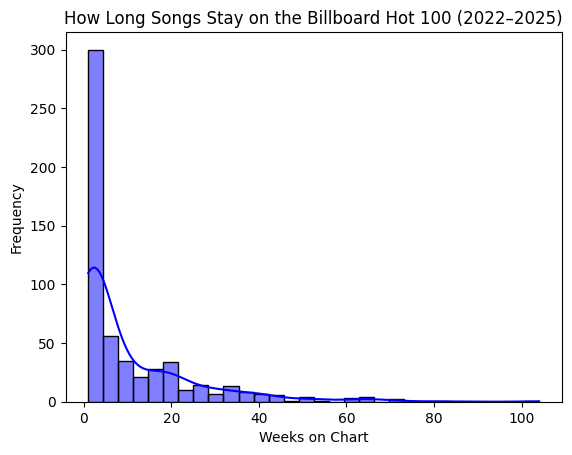

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(weeks_on_chart_df["wks_on_chart"], bins=30, kde=True, color="blue", edgecolor="black")
plt.title("How Long Songs Stay on the Billboard Hot 100 (2022–2025)")
plt.xlabel("Weeks on Chart")
plt.ylabel("Frequency")
plt.show()

*This is great, but if I want to predict a song's wks_on_chart from first week data or prior, we need to remove all songs whose entry week was before our first recorded week (Jan 1st, 2022)*

*Also, the goal is to collect data to use the following predictor variables:*

*- Number of daily UGCs to song's sound(s) (TikTok and Instagram)*

*- SocialBlade Social Media data*

*- Spotify Metadata (Dancability etc.)*

*- Genius Lyrics*

*- Genre-weighted Typicality (Yearly, Monthly) as per Askin and Mauskapf*

*- First week Billboard Hot 100 position*

*- Is the artist associated with the song signed to a major label?*

*- Is the artist in the co-signed by a much larger artist or influencer?*

*As the Spotify's deprecated Audio Features API, I look to get similar results with an alternative data source. Some recommendations online say to use the AcousticBrainz / MusicBrainz as per Votter (2021, 2022)*

In [12]:
len(total_hot_100["title"].unique())

2379